In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torchphysics as tp
import torch
import pytorch_lightning as pl

In [2]:
# Problem params:
x0 = [0.0, 0.5] # inital position/speed
t_end = 10 # sec
D = 1
omega_0 = 1
mu = 0.75
# Spaces 
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable
K1 = tp.spaces.R1('k1') # parameter
K2 = tp.spaces.R1('k2') # parameter
F = tp.spaces.R1('f') # function output space name
# Domains
A_t = tp.domains.Interval(T, 0.0, t_end)
K_int = tp.domains.Interval(K1, 0, 2)
K_int2 = tp.domains.Interval(K2, 5, 10)
#Sampler (for inner sampler add the left boundary, else delta right-hand side can't be learned)
inner_sampler = tp.samplers.RandomUniformSampler(A_t, n_points = 4000) + tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()
initial_u_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()
initial_v_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()

In [3]:
# Defining function set
Fn_space = tp.spaces.FunctionSpace(A_t, F)

def f1(k1, t):
    return torch.sin(k1*t)

def delta(k2, t):
    return k2 * torch.isclose(t, torch.tensor(0.0))

param_sampler = tp.samplers.RandomUniformSampler(K_int, n_points=100)
param_sampler_delta = tp.samplers.RandomUniformSampler(K_int2, n_points=50)
Fn_set_1 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f1)
Fn_set_2 = tp.domains.CustomFunctionSet(Fn_space, param_sampler_delta, delta)
Fn_set = Fn_set_1 + Fn_set_2

In [4]:
# custom convolution that should be used for the branch,
# can also apply some pooling, or something else, if needed.
# Just the output dimension and input of the linear layers has to fit
class ConvolutionLayers(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 1, 51, padding=25)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        return self.activation(self.conv1(x))

# custom activation, from old notebook
class DampedSine(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        alpha = 0.1
        return torch.exp(-alpha * Tensor) * torch.sin(Tensor)

# Model
dis_sampler = (tp.samplers.GridSampler(A_t.boundary_left, n_points = 1)
                + tp.samplers.GridSampler(A_t, n_points = 800)).make_static()
trunk_net = tp.models.FCTrunkNet(T, hidden=(50, 50),
                                 xavier_gains=[3/5, 3/5, 0.0])
branch_net = tp.models.ConvBranchNet1D(Fn_space, convolutional_network=ConvolutionLayers(),
                                       hidden=(600, 500, 250), discretization_sampler=dis_sampler)
model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=80)

In [5]:
def u_constrain(u, t):
    return u * t **2 / t_end**2 + x0[1]*t + x0[0]

def ode_residual(u, f, t):
    u_con = u_constrain(u, t)
    u_t = tp.utils.grad(u_con, t)
    lhs = tp.utils.grad(u_t, t) + 2*D*u_t + omega_0**2 * (u_con + mu*u_con**3) 
    return lhs - f

ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             function_set=Fn_set, 
                                             input_sampler=inner_sampler, 
                                             name='ode_condition',
                                             residual_fn=ode_residual)

In [6]:
"""
def initial_residual(u):
    return u - x0[0]

initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                                 function_set=Fn_set, 
                                                 input_sampler=initial_u_sampler, 
                                                 residual_fn=initial_residual, weight=1000)

def initial_speed_residual(u, t):
    return tp.utils.grad(u, t) - x0[1]

initial_speed_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                                       function_set=Fn_set, 
                                                       input_sampler=initial_u_sampler, 
                                                       residual_fn=initial_residual, weight=1000)
"""

'\ndef initial_residual(u):\n    return u - x0[0]\n\ninitial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, \n                                                 function_set=Fn_set, \n                                                 input_sampler=initial_u_sampler, \n                                                 residual_fn=initial_residual, weight=1000)\n\ndef initial_speed_residual(u, t):\n    return tp.utils.grad(u, t) - x0[1]\n\ninitial_speed_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, \n                                                       function_set=Fn_set, \n                                                       input_sampler=initial_u_sampler, \n                                                       residual_fn=initial_residual, weight=1000)\n'

In [7]:
solver = tp.solver.Solver([ode_cond])

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=30000, 
                     logger=False, 
                     enable_checkpointing=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 933 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
933 K     Trainable params
0         Non-trainable params
933 K     Total params
3.735     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarnin

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.5, 
                            optimizer_args={'max_iter':2, 'history_size': 100})

# here now use grid points:
ode_cond.input_sampler = tp.samplers.GridSampler(A_t, n_points=4000).make_static()
# also fix parameters for input functions and take some more:
Fn_set_1.parameter_sampler.n_points = 120
Fn_set_1.parameter_sampler = Fn_set_1.parameter_sampler.make_static()
Fn_set_2.parameter_sampler.n_points = 80
Fn_set_2.parameter_sampler = Fn_set_2.parameter_sampler.make_static()

solver = tp.solver.Solver(train_conditions=[ode_cond], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=2500, 
                     logger=False, 
                     enable_checkpointing=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 933 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
933 K     Trainable params
0         Non-trainable params
933 K     Total params
3.735     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

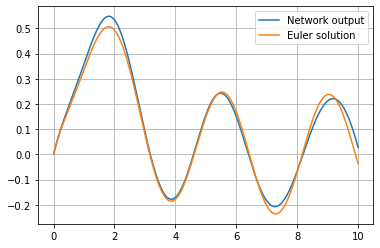

In [9]:
import matplotlib.pyplot as plt

k0 = 1.8
def f(t):
    a = torch.sin(k0*t)
    return a


model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(A_t, 2000)
grid_points = grid_sampler.sample_points().unsqueeze(0)
out = u_constrain(model(grid_points).as_tensor.detach()[0], grid_points.as_tensor.squeeze(0))
# euler:
grid_p = grid_points.as_tensor.squeeze(0)
dis_f = f(grid_p).squeeze(0)
delta_t = grid_p[1] - grid_p[0]
u, v = torch.zeros_like(dis_f), torch.zeros_like(dis_f)
u[0] = x0[0]
v[0] = x0[1]
for i in range(len(u)-1):
    v[i+1] = v[i] + delta_t * (dis_f[i] - 2*D*v[i] - omega_0**2*(u[i] + mu * u[i]**3))
    u[i+1] = u[i] + delta_t * v[i]
plt.plot(grid_p, out)
plt.plot(grid_p, u)
plt.grid()
plt.legend(['Network output', 'Euler solution'])

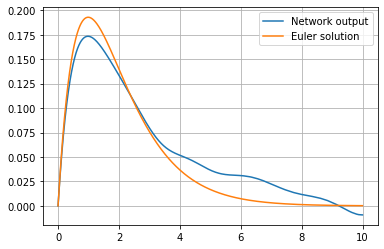

In [10]:
import matplotlib.pyplot as plt

k0 = 5.0
def f(t):
    a = k0 * torch.isclose(t, torch.tensor(0.0))
    return a


model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(A_t.boundary_left, 1) + tp.samplers.GridSampler(A_t, 2000)
grid_points = grid_sampler.sample_points()
out = u_constrain(model(grid_points).as_tensor.detach()[0], grid_points.as_tensor)
# euler:
grid_p = grid_points.as_tensor
dis_f = f(grid_p).squeeze(0)
delta_t = grid_p[1] - grid_p[0]
u, v = torch.zeros_like(dis_f), torch.zeros_like(dis_f)
u[0] = x0[0]
v[0] = x0[1]
for i in range(len(u)-1):
    v[i+1] = v[i] + delta_t * (dis_f[i] - 2*D*v[i] - omega_0**2*(u[i] + mu * u[i]**3))
    u[i+1] = u[i] + delta_t * v[i]
plt.plot(grid_p, out)
plt.plot(grid_p, u)
plt.grid()
plt.legend(['Network output', 'Euler solution'])